In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

In [2]:
df = pd.read_csv('Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv')
#print(df)

In [3]:
df.columns

Index(['Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma',
       'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'Ace2',
       ...
       'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
       'Vgf'],
      dtype='object', length=170)

In [4]:
df.columns[7:10]

Index(['Cell_class', 'Neuron_cluster_ID', 'Ace2'], dtype='object')

In [5]:
data=df.to_numpy()

In [6]:
from scipy.sparse import csr_matrix

In [43]:

counts = csr_matrix(data[:,9:], dtype=np.float32)
adata = anndata.AnnData(counts)
adata

print(counts.shape,data.shape)

(1027848, 161) (1027848, 170)


In [8]:
#df[['Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID']]

In [44]:
adata.obs_names=data[:,0]
adata.var_names=df.columns[9:]


In [45]:
coord=df[['Centroid_X', 'Centroid_Y']].to_numpy()
ct = df[['Cell_class']]

print(len(adata.obs_names),len(adata.var_names), coord.shape, ct.shape)
adata.obsm['spatial']= coord 
adata.obs['cluster']= ct 


1027848 161 (1027848, 2) (1027848, 1)


In [54]:
nadata= adata.copy()

In [55]:
sc.pp.filter_cells(nadata, min_counts=300)
nadata

AnnData object with n_obs × n_vars = 162073 × 161
    obs: 'cluster', 'n_counts'
    obsm: 'spatial'

In [56]:
adata.X=adata.X.toarray()


In [57]:
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_genes(adata, min_cells=1)


In [58]:
#adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [59]:
adata_dis500 = adata.copy()

In [60]:
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.4)


KeyboardInterrupt: 

ValueError: Invalid RGBA argument: nan

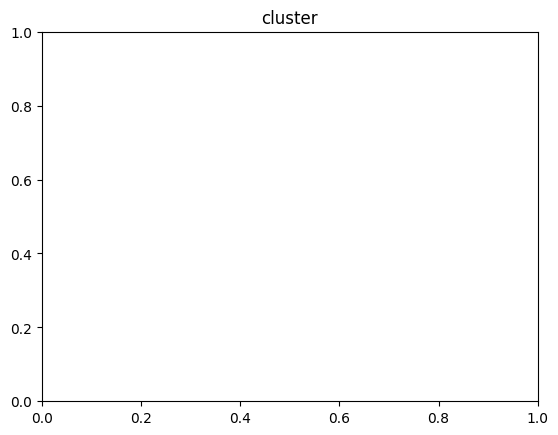

In [63]:
sc.pl.spatial(adata, color='cluster',spot_size=100)

In [64]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

AttributeError: 'DataFrame' object has no attribute 'pp'

In [ ]:
# We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0)
print(df_cellchat_filtered.shape)


In [ ]:
df_cellchat

In [ ]:
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat, dis_thr=500, heteromeric=True, pathway_sum=True)